In [1]:
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# !pip install pmdarima
import pmdarima as pm
from pmdarima import auto_arima

tweet_vaderized = pd.read_excel('data/sentitweet610.xlsx')
reddit_vaderized = pd.read_excel('data/sentireddit610.xlsx')
startDate = pd.to_datetime('20160601')
endDate = pd.to_datetime('20161001')
i_hour = pd.date_range(start=startDate, end=endDate,freq='H')

tweet_senti = tweet_vaderized.resample('H', on='dtime').mean().reindex(i_hour).fillna(0).loc[:,['vader_compound']]
redditmidsum = reddit_vaderized.resample('H', on='time').sum().reindex(i_hour).fillna(0)
redditmidsum['sentivader'] = (redditmidsum.vaderscore / redditmidsum.scoren).fillna(0)
reddit_senti =  redditmidsum.loc[:,['sentivader']]
senti = pd.concat([tweet_senti, reddit_senti], axis=1)
senti.columns = ['tweet_senti','reddit_senti']
senti['tweet_count'] = (tweet_vaderized.resample('H', on='dtime').count().loc[:,['vader_compound']])
senti['reddit_count'] = (reddit_vaderized.resample('H', on='time').sum().loc[:,['scoren']])
senti['tweet_count'] = np.log(senti['tweet_count']+1)
senti['reddit_count'] = np.log(senti['reddit_count']+1)
senti = senti.fillna(0)

In [50]:
from arch.unitroot import ADF,DFGLS,PhillipsPerron,KPSS
print(ADF(senti['tweet_senti'].values))
print(DFGLS(senti['tweet_senti'].values))
print(PhillipsPerron(senti['tweet_senti'].values))
print(KPSS(senti['tweet_senti'].values))

   Augmented Dickey-Fuller Results   
Test Statistic                 -8.418
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
      Dickey-Fuller GLS Results      
Test Statistic                 -2.142
P-value                         0.032
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -2.57 (1%), -1.95 (5%), -1.63 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -52.356
P-value                         0.000
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Nu

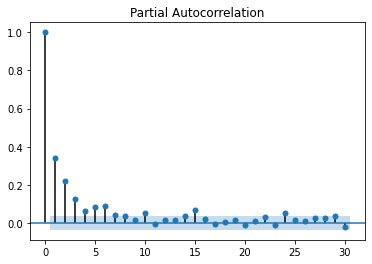

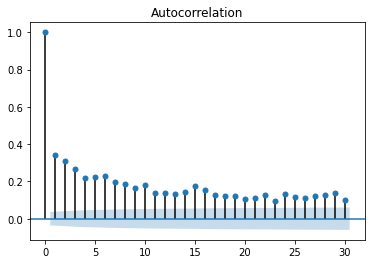

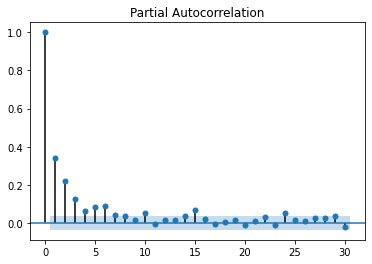

In [62]:
import statsmodels.tsa.api as smt

smt.graphics.plot_acf(senti['tweet_senti'], lags=30)
smt.graphics.plot_pacf(senti['tweet_senti'], lags=30)
    
# def tsplot(y, lags=None, title='', figsize=(14, 10)):
#     fig = plt.figure(figsize = figsize)
#     layout = (2, 2)
#     ts_ax = plt.subplot2grid(layout, (0, 0))
#     hist_ax = plt.subplot2grid(layout, (0, 1))
#     acf_ax = plt.subplot2grid(layout, (1, 0))
#     pacf_ax = plt.subplot2grid(layout, (1, 1))

#     y.plot(ax = ts_ax)
#     ts_ax.set_title(title)

#     y.plot(ax = hist_ax, kind = 'hist', bins = 30)
#     hist_ax.set_title('Histogram')

#     smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
#     smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
#     [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
#     plt.tight_layout()
#     return ts_ax, acf_ax, pacf_ax

# tsplot(senti['tweet_senti'], title = 'Consumer Sentiment', lags = 30)


In [3]:
dates = senti.index
data = senti[['tweet_count','tweet_senti']]
data = data.fillna(0)
data.columns = ['count','senti']
data['senti'] = data['senti'].shift().fillna(0)
split_train = math.floor(len(data) * 0.2)

train = data[:-split_train]
test = data[-split_train:]

In [4]:
kalmanData = pd.concat([senti['reddit_senti'], senti['tweet_senti']],axis=1)
kalmanData.columns = ['reddit', 'tweet']

In [2]:
ar = pm.arima.ARIMA(order = (24,0,0))
ar.fit(train['senti'])
# ar.summary()

In [1]:
arx = pm.arima.ARIMA (order = (24,0,0))
arx.fit(train['senti'],X =pd.DataFrame(train['count']))

In [5]:
model = pm.auto_arima ( train['senti'], 
                        start_p=0, start_q=0, max_p=2, max_q=2, 
                        m=24, start_P=0, start_Q=0, max_P=1, max_Q=1,   
                        seasonal=False, stationary=True, 
                        trace=True, error_action='ignore', suppress_warnings=True,                         
                        stepwise=True, scoring='mse')
# model.summary()

/Users/jacqualync/opt/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (24) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-623.638, Time=2.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-976.203, Time=2.33 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-857.664, Time=4.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=485.447, Time=0.79 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1107.322, Time=2.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1207.687, Time=11.98 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1200.393, Time=9.79 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1196.570, Time=9.89 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1205.463, Time=13.92 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1188.128, Time=2.11 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 60.239 seconds


In [6]:
model_count = pm.auto_arima(train['senti'], X = pd.DataFrame(train['count']),
                            start_p=0, start_q=0, max_p=2, max_q=2,    
                            seasonal=False, stationary=True, 
                            trace=True, error_action='ignore', suppress_warnings=True,                         
                            stepwise=True, scoring='mse')
# model_count.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-857.710, Time=2.76 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1061.480, Time=1.42 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1000.289, Time=3.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-806.348, Time=0.99 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1155.824, Time=5.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1217.171, Time=12.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1214.575, Time=10.43 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1210.608, Time=14.51 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1215.999, Time=13.62 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1194.536, Time=8.32 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 72.511 seconds


In [7]:
model_seasonal = pm.auto_arima(train['senti'], 
                                start_p=0, start_q=0, max_p=2, max_q=2, 
                                m=24, start_P=0, start_Q=0, max_P=1, max_Q=1,           
                                stationary=True, seasonal=True, 
                                trace=True, error_action='ignore', suppress_warnings=True,                         
                                stepwise=True, scoring='mse')
# model_seasonal.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-623.638, Time=1.09 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-996.453, Time=11.66 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-890.047, Time=11.21 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=485.447, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-976.203, Time=1.54 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-1011.627, Time=41.22 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-993.763, Time=25.55 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=-708.064, Time=33.33 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=-1128.927, Time=56.73 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=-1115.165, Time=45.41 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-1116.181, Time=49.66 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-1107.322, Time=2.44 sec
 ARIMA(2,0,1)(1,0,1)[24] intercept   : AIC=-1212.718, Time=48.90 sec
 ARIMA(2,0,1)(0,0,1)[24] intercept   : AIC=-1207.698, Time=38.63 sec
 AR

In [8]:
model_seasonalcount = pm.auto_arima(train['senti'], X = pd.DataFrame(train['count']),
                                    start_p=0, start_q=0, max_p=2, max_q=2, 
                                    m=24, start_P=0, start_Q=0, max_P=1, max_Q=1,   
                                    seasonal=True, stationary=True, 
                                    trace=True, error_action='ignore', suppress_warnings=True,                         
                                    stepwise=True, scoring='mse')                     
# model_seasonalcount.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-857.710, Time=1.29 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-1070.485, Time=28.05 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-1011.772, Time=17.75 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-806.348, Time=0.78 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-1061.480, Time=0.93 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-1075.044, Time=28.65 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-1069.449, Time=36.51 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=-879.183, Time=21.49 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=-1166.261, Time=107.41 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=-1159.631, Time=38.70 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-1160.151, Time=60.09 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-1155.824, Time=3.93 sec
 ARIMA(2,0,1)(1,0,1)[24] intercept   : AIC=-1221.508, Time=138.86 sec
 ARIMA(2,0,1)(0,0,1)[24] intercept   : AIC=-1217.356, Time=53.58 

In [9]:
def RMSE(pred, truth):
    return math.sqrt(mean_squared_error(truth, pred))

# OI

In [10]:
reddit_hourvar_mean = reddit_vaderized.resample('H', on='time').var().vadern.reindex(i_hour).mean() #fillna(0)
reddit_var = kalmanData['reddit'].to_numpy(dtype=float).var()
tweet_var = kalmanData['tweet'].to_numpy(dtype=float).var()
print(reddit_var,tweet_var,reddit_hourvar_mean)
H=1
R_r = reddit_hourvar_mean
predx = 72  #count可以用之前24h的平均？
datada = data[:-predx] # datada, datatp = data[:-predx], data[-predx:]
#it = range(length, len(data) - predx)

0.06726473971947694 0.048915568843057415 0.2684919913595351


In [11]:
P0_rr = reddit_var
K_r = P0_rr * H / (H * P0_rr * H + R_r)
print("K_r with Reddit as P0", K_r)
P0_rt = tweet_var
K_t = P0_rt * H / (H * P0_rt * H + R_r)
print("K_r with Twitter as P0", K_t)

K_r with Reddit as P0 0.20033772518367723
K_r with Twitter as P0 0.15410965262401422


In [12]:
def show_result(lag, da_r, pred_r): 
    ### VALIDATION ###
    plt.figure(figsize=(5, 3))
    # 1) see if residuals are zero mean gaussian (MAKE SURE TO SET DELAY TO ZERO!)
    res = kalmanData[pred_r][lag:-predx] - kalmanData['reddit'][lag:-predx].to_numpy()  # all Reddits
    (mu, sigma) = norm.fit(res)
    # the residual error plot (histogram + normal distr)
    n, bins, patches = plt.hist(res, density=True, facecolor='C0', alpha=0.75)
    y = norm.pdf(bins, loc=mu, scale=sigma)
    plt.plot(bins, y, 'r--', linewidth=2)
    plt.title("Wildfire Sentiment with $\mu=" + str(round(mu, 4)) + "$ and $\sigma =" + str(round(sigma, 4)) + "$")
    plt.show()
    # 2) MSE
    mse_t = RMSE(kalmanData[da_r][lag:-predx], kalmanData['tweet'][lag:-predx])**2   
    mse_r = RMSE(kalmanData[da_r][lag:-predx], kalmanData['reddit'][lag:-predx])**2 #sum((X - Y_reddit) ** 2) / X.size
    print("mse for tweet / reddit ", mse_t, mse_r)

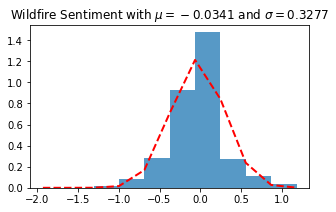

mse for tweet / reddit  0.08245538576163151 0.06940649899049903


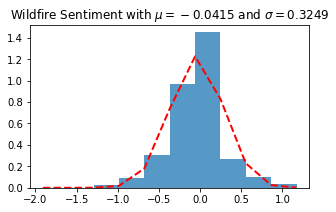

mse for tweet / reddit  0.0797690206414858 0.07678256398652554


In [15]:
def OI_arma(da_r, pred_r, K_r):    
    kalmanData[da_r], kalmanData[pred_r]= np.nan, np.nan 
    model.fit(datada['senti'])
    intercept,ar1,ar2,ma1,_ = model.params()
    resid = model.resid()
    lag=2
    his = datada['senti'].values.tolist()[0:lag]    
    for i in range(lag, len(datada)):        
        xf = intercept+ar1*his[-1]+ar2*his[-2]+resid[i]+ma1*resid[i-1]   
        xa = xf + K_r * (kalmanData['reddit'].iloc[i] - H * xf)  # update    
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xa
        his.append(xa)
    # predict ahead
    for i in range(len(datada), len(data)):
        xf = intercept+ar1*his[-1]+ar2*his[-2]   
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xf
        his.append(xf) 
    show_result(lag, da_r, pred_r)

OI_arma('da_oi_arma_r', 'pred_oi_arma_r', K_r)
OI_arma('da_oi_arma_t', 'pred_oi_arma_t', K_t)
#plot_result(['da_oi_orr', 'da_oi_ort'], 288)

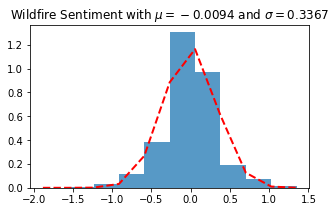

mse for tweet / reddit  0.09235334326895756 0.0725361003202581


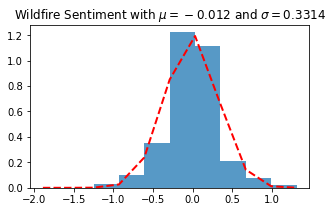

mse for tweet / reddit  0.09038086735562736 0.07869810783438128


In [16]:
def OI_sarma(da_r, pred_r, K_r):    
    kalmanData[da_r], kalmanData[pred_r]= np.nan, np.nan 
    model_seasonal.fit(datada['senti'])
    resid = model_seasonal.resid()
    intercept,ar1,ar2,ma1,ar24,ma24,_ = model_seasonal.params()
    lag=26   
    his = datada['senti'].values.tolist()[0:lag]    
    for i in range(lag, len(datada)):        
        xf = intercept+ar1*his[-1]+ar2*his[-2]+ar24*(his[-24]-ar1*his[-25]-ar2*his[-26])+resid[i]+ma1*resid[i-1]+ma24*(resid[i-24]+ma1*resid[i-25])
        xa = xf + K_r * (kalmanData['reddit'].iloc[i] - H * xf)  # update    
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xa
        his.append(xa)
    # predict ahead
    for i in range(len(datada), len(data)):
        xf = intercept+ar1*his[-1]+ar2*his[-2]+ar24*(his[-24]-ar1*his[-25]-ar2*his[-26])
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xf
        his.append(xf) 
    show_result(lag, da_r, pred_r)

OI_sarma('da_oi_sarma_r', 'pred_oi_sarma_r', K_r)
OI_sarma('da_oi_sarma_t', 'pred_oi_sarma_t', K_t)

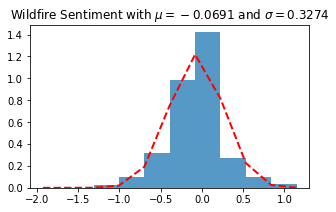

mse for tweet / reddit  0.07486353269300473 0.07159200024019274


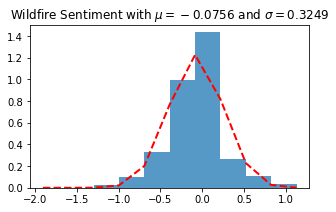

mse for tweet / reddit  0.07255312204885513 0.07961692283688179


In [17]:
def OI_armax(da_r, pred_r, K_r):    
    kalmanData[da_r], kalmanData[pred_r]= np.nan, np.nan 
    model_count.fit(datada['senti'],X=pd.DataFrame(datada['count']))
    intercept,count,ar1,ar2,ma1,_ = model_count.params()
    resid = model_count.resid()
    lag=2
    his = datada['senti'].values.tolist()[0:lag]   
    for i in range(lag, len(datada)):        
        xf = count*datada['count'][i]+intercept+ar1*his[-1]+ar2*his[-2]+resid[i]+ma1*resid[i-1]
        xa = xf + K_r * (kalmanData['reddit'].iloc[i] - H * xf)  # update    
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xa
        his.append(xa - (1-K_r*H)*count*datada['count'][i])
    # predict ahead
    for i in range(len(datada), len(data)):
        xf = count*data['count'][i]+intercept+ar1*his[-1]+ar2*his[-2]
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xf
        his.append(xf - count*data['count'][i]) 
    show_result(lag, da_r, pred_r)

OI_armax('da_oi_armax_r', 'pred_oi_armax_r', K_r)
OI_armax('da_oi_armax_t', 'pred_oi_armax_t', K_t)

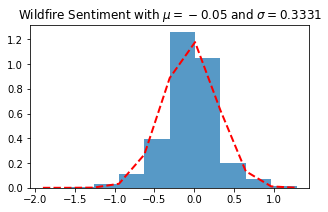

mse for tweet / reddit  0.08139588779354798 0.0725347553187924


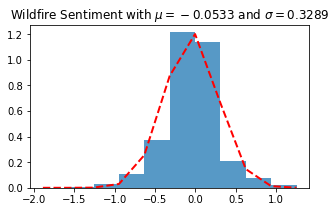

mse for tweet / reddit  0.07923275403594265 0.07942198261846103


In [18]:
def OI_sarmax(da_r, pred_r, K_r):    
    kalmanData[da_r], kalmanData[pred_r]= np.nan, np.nan 
    model_seasonalcount.fit(datada['senti'],X=pd.DataFrame(datada['count']))
    resid = model_seasonalcount.resid()
    intercept,count,ar1,ar2,ma1,ar24,ma24,_ = model_seasonalcount.params()
    lag=26
    his = datada['senti'].values.tolist()[0:lag]  
    for i in range(lag, len(datada)):        
        xf = count*datada['count'][i]+intercept+ar1*his[-1]+ar2*his[-2]+ar24*(his[-24]-ar1*his[-25]-ar2*his[-26])+resid[i]+ma1*resid[i-1]+ma24*(resid[i-24]+ma1*resid[i-25])
        xa = xf + K_r * (kalmanData['reddit'].iloc[i] - H * xf)  # update    
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xa
        his.append(xa - (1-K_r*H)*count*datada['count'][i])
    # predict ahead
    for i in range(len(datada), len(data)):
        xf = count*data['count'][i]+intercept+ar1*his[-1]+ar2*his[-2]+ar24*(his[-24]-ar1*his[-25]-ar2*his[-26])
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xf
        his.append(xf - count*data['count'][i]) 
    show_result(lag, da_r, pred_r)

OI_sarmax('da_oi_sarmax_r', 'pred_oi_sarmax_r', K_r)
OI_sarmax('da_oi_sarmax_t', 'pred_oi_sarmax_t', K_t)

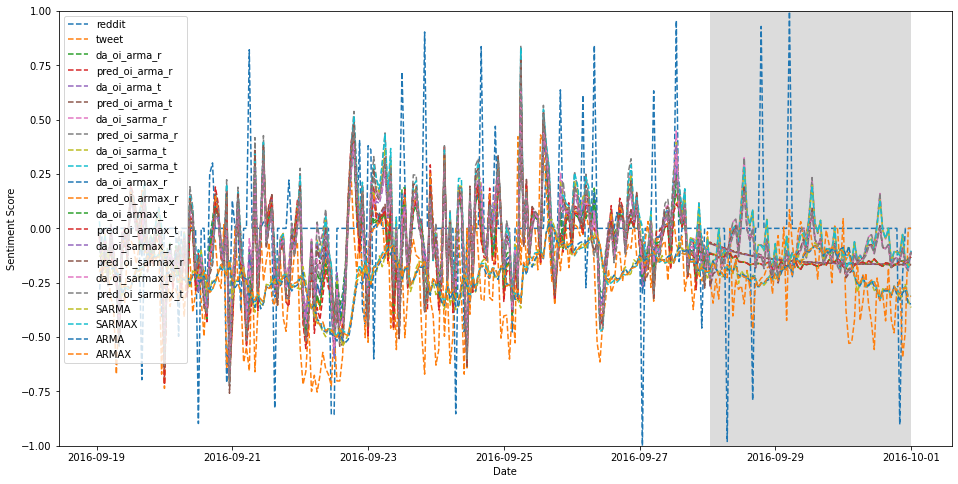

In [36]:
def plot_result(paras, part):    
    #part = 0
    plt.figure(figsize=(16,8)) 
#     plt.plot(kalmanData['tweet'][-part:], linestyle='-', label='Tweets', alpha=0.7)
#     plt.plot(kalmanData['reddit'][-part:], linestyle='-', label='Reddits', alpha=0.7) 
    for para in paras:
        plt.plot(kalmanData[para][-part:], linestyle='--', label=para) 
    plt.fill_between(dates[-predx:], -1, 1,facecolor='gainsboro', interpolate=True)
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score")
    plt.legend()
    plt.ylim([-1, 1])
    plt.show()

plot_result(kalmanData.columns, part=288)

In [3]:
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef) + 1):
        yhat += coef[i - 1] * history[-i]
    return yhat

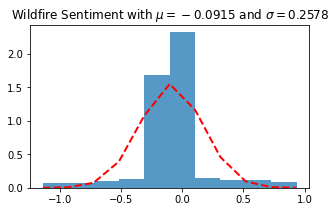

mse for tweet / reddit  0.055746053133017955 0.047843263085307924


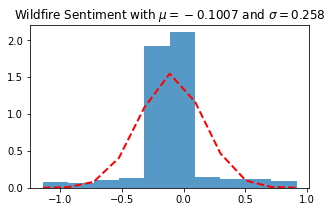

mse for tweet / reddit  0.053178007234203996 0.054902512741301854


In [68]:
def OI_ar(da_r, pred_r, K_r):    
    kalmanData[da_r], kalmanData[pred_r]= np.nan, np.nan 
    ar.fit(datada['senti'])
    intercept,ar_coef = ar.params()[0], ar.arparams()
    resid = ar.resid()
    lag=24
    his = datada['senti'].values.tolist()[0:lag]    
    for i in range(lag, len(datada)):        
        xf = intercept + predict(ar_coef, his) 
        xa = xf + K_r * (kalmanData['reddit'].iloc[i] - H * xf)  # update    
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xa
        his.append(xa)
    # predict ahead
    for i in range(len(datada), len(data)):
        xf = intercept + predict(ar_coef, his) 
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xf
        his.append(xf) 
    show_result(lag, da_r, pred_r)

OI_ar('da_oi_ar_r', 'pred_oi_ar_r', K_r)
OI_ar('da_oi_ar_t', 'pred_oi_ar_t', K_t)

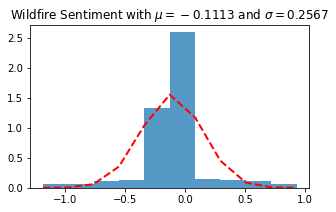

mse for tweet / reddit  0.052060370872730674 0.05004659572075151


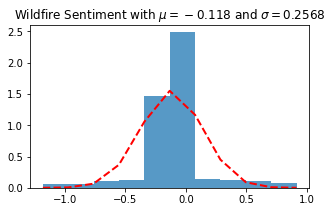

mse for tweet / reddit  0.049860523121126855 0.057159691054573296


In [69]:
def OI_arx(da_r, pred_r, K_r):    
    kalmanData[da_r], kalmanData[pred_r]= np.nan, np.nan 
    arx.fit(datada['senti'],X=pd.DataFrame(datada['count']))
    intercept,count,ar_coef = arx.params()[0],arx.params()[1], arx.arparams()
    resid = arx.resid()
    lag=24
    his = datada['senti'].values.tolist()[0:lag]    
    for i in range(lag, len(datada)):        
        xf = count*data['count'][i] + intercept + predict(ar_coef, his) 
        xa = xf + K_r * (kalmanData['reddit'].iloc[i] - H * xf)  # update    
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xa
        his.append(xa - (1-K_r*H)*count*data['count'][i])
    # predict ahead
    for i in range(len(datada), len(data)):
        xf = count*data['count'][i] + intercept + predict(ar_coef, his) 
        kalmanData[pred_r].iloc[i], kalmanData[da_r].iloc[i] = xf,xf
        his.append(xf - count*data['count'][i]) 
    show_result(lag, da_r, pred_r)

OI_arx('da_oi_arx_r', 'pred_oi_arx_r', K_r)
OI_arx('da_oi_arx_t', 'pred_oi_arx_t', K_t)

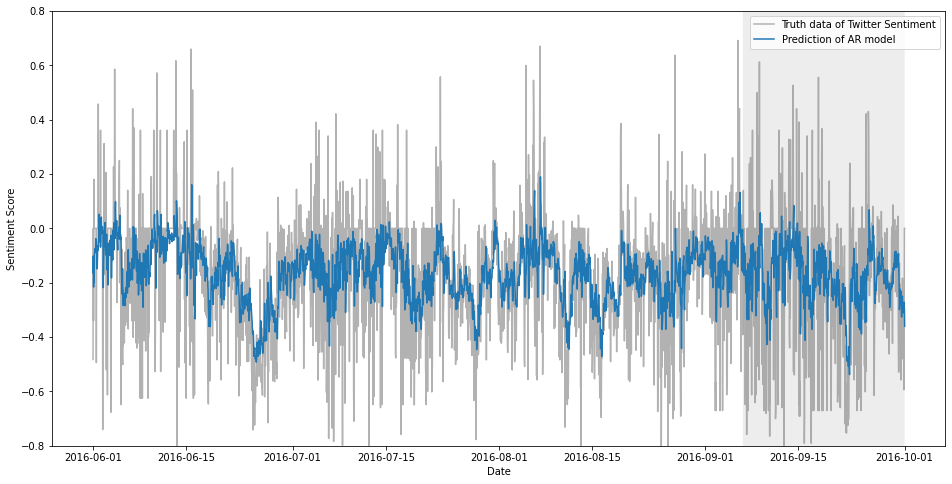

In [73]:
plt.figure(figsize=(16,8)) #
plt.plot(kalmanData['tweet'],linestyle='-',color='grey',alpha=0.6, label = 'Truth data of Twitter Sentiment')
plt.plot(kalmanData['AR'],linestyle='-',label = 'Prediction of AR model')
#plt.plot(kalmanData['SARMA'],linestyle='--',label = 'Prediction of SARMA model')
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.fill_between(dates[-split_train:], -1, 1,facecolor='gainsboro',alpha=0.5, interpolate=True)
plt.ylim([-0.8, 0.8])
plt.show()

In [74]:
kalmanData.to_excel('sarimaoi.xlsx', index=True)